<a href="https://colab.research.google.com/github/santiagoviteri01/mmia_nlp_2023_2024/blob/main/taller_6_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 6**

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
file = '/content/drive/MyDrive/spa.txt'

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH #and \
#            p[0].startswith(eng_prefixes)
    except:
        print(p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, file):
    text = open(file, encoding='utf-8').read().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in text ]
    pairs = [pair for pair in pairs if len(pair) == 2]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    pairs = filterPairs(pairs)

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [8]:
input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

Counted words:
eng 12105
spa 23411


In [9]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, input_lang, output_lang, max_length):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        input_sentence = self.pairs[index][0]
        output_sentence = self.pairs[index][1]
        input_tensor = self.tensor_from_sentence(self.input_lang, input_sentence)
        output_tensor = self.tensor_from_sentence(self.output_lang, output_sentence)
        return input_tensor, output_tensor

    def tensor_from_sentence(self, lang, sentence):
        indices = [lang.word2index[word] for word in sentence.split(' ')]
        indices.append(EOS_token)
        return torch.tensor(indices, dtype=torch.long)

In [10]:
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)

    # Find the maximum length of input and target sequences in this batch
    input_max_length = max(len(s) for s in input_seqs)
    target_max_length = max(len(s) for s in target_seqs)

    # Find the overall maximum length for both input and target sequences
    max_length = max(input_max_length, target_max_length)

    # Pad input sequences to the same maximum length
    padded_input_seqs = [torch.cat((s, torch.zeros(max_length - len(s), dtype=torch.long))) for s in input_seqs]

    # Pad target sequences to the same maximum length
    padded_target_seqs = [torch.cat((s, torch.zeros(max_length - len(s), dtype=torch.long))) for s in target_seqs]

    # Stack into tensors
    input_tensor = torch.stack(padded_input_seqs)
    target_tensor = torch.stack(padded_target_seqs)

    return input_tensor, target_tensor



In [11]:
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [12]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

# MultiheadAttention module
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

# Transformer Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        super().__init__()
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        return x

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

# Transformer model class
class TransformerPredictor(pl.LightningModule):
    def __init__(self, vocab_size, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Usar una capa de embedding en lugar de la capa lineal
        self.embedding = nn.Embedding(self.hparams.vocab_size, self.hparams.model_dim)
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        # Aplicar la capa de embeddings en la secuencia de entrada
        x = self.embedding(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.98), eps=1e-9)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        #print("Input shape:", x.shape, "Target shape:", y.shape)
        mask = (x != 0).unsqueeze(1).unsqueeze(2)
        y_hat = self(x, mask)
        #print("Output shape:", y_hat.shape)
        loss = F.cross_entropy(y_hat.view(-1, y_hat.size(-1)), y.view(-1),ignore_index=0)
        self.log('train_loss', loss)
        return loss

<ipython-input-12-f71ab26ca475>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

def load_and_plot_metrics(log_dir):
    # Load metrics CSV
    metrics = pd.read_csv(f"{log_dir}/metrics.csv")


    # Aggregate metrics
    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)


    df_metrics = pd.DataFrame(aggreg_metrics)

    # Print the available columns to verify their names
    #print(df_metrics)

    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Training Loss')
    #plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to create DataModule, train model, and evaluat

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | embedding           | Embedding          | 749 K  | train
1 | positional_encoding | PositionalEncoding | 0      | train
2 | transformer         | TransformerEncoder | 17.1 K | train
3 | output_net          | Sequential         | 773 K  | train
-------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.160     Total estimated model params size (MB)
34        Modules in train mode
0         Module

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


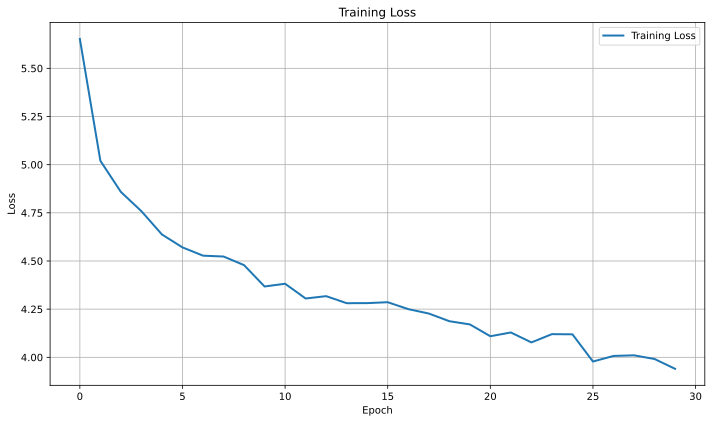

In [116]:
# Hyperparameters
vocab_size = max(input_lang.n_words, output_lang.n_words)
model_dim = 32
num_classes = vocab_size
num_heads = 2
num_layers = 2
lr = 1e-3
warmup = 4000
max_iters = 500
dropout = 0.1
input_dropout = 0.1
batch_size = 64
num_epochs = 30

    # Crear dataset de traducción
train_dataset = TranslationDataset(pairs, input_lang, output_lang, max_length=MAX_LENGTH)

    # Crear DataLoader con relleno
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Crear modelo
model = TransformerPredictor(vocab_size, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout, input_dropout)
logger = pl.loggers.CSVLogger(save_dir="logs", name=f"_exp_name")

# Move the model to the appropriate device
model.to(device)
trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger
    )
trainer.fit(model, train_loader)
load_and_plot_metrics(trainer.logger.log_dir)
# Entrenar modelo

In [117]:
import torch

def translate_word(model, word, input_lang, output_lang, device):
    """
    Translates a single word from the source language to the target language using the provided model.

    Parameters:
    - model: The trained transformer model
    - word: The word to be translated (string)
    - input_lang: The source language vocabulary object with a `word2index` attribute
    - output_lang: The target language vocabulary object with an `index2word` attribute
    - device: The device to run the model on ('cpu' or 'cuda')

    Returns:
    - Translated word in the target language (string)
    """
    model.eval()  # Set the model to evaluation mode

    # Check if the word is in the vocabulary, otherwise use a default index (e.g., 0 for padding or a special index for unknown)
    input_tensor = torch.tensor([input_lang.word2index.get(word, 0)], dtype=torch.long).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model(input_tensor)

        # Assuming the model outputs logits for each word in the target language
        # For simplicity, take the output at the first position of the sequence
        output = output[0, 0]  # Adjust indexing based on your model's output shape

        # Get the index of the most likely word
        _, topi = output.topk(1)
        translated_index = topi[0].item()

        # Convert the index to a word
        translated_word = output_lang.index2word.get(translated_index, '<UNK>') # Use '<UNK>' if the index is not found

    return translated_word

# Example usage
input_word = "car"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
translated_word = translate_word(model, input_word, input_lang, output_lang, device)
print('Translated Word:', translated_word)

Translated Word: coche


In [125]:
def translate_sentence(model, sentence, input_lang, output_lang, device):
    model.eval()  # Set the model to evaluation mode
    # Moved the device assignment to tensorFromSentence
    def tensorFromSentence(lang, sentence, device): # Added device as an argument
        indexes = [lang.word2index.get(word, 0) for word in sentence.split(' ')]
        indexes.append(EOS_token)  # Add EOS token as an integer
        print("Sentence indices:", indexes)
        return torch.tensor(indexes, dtype=torch.long, device=device).unsqueeze(0) # Use device here

    # Pass device to tensorFromSentence
    input_tensor = tensorFromSentence(input_lang, sentence, device)

    with torch.no_grad():
        output = model(input_tensor)
        #print("Model output logits:", output)

        output = output.squeeze(0)  # Remove batch dimension
        #print("Squeezed output:", output)

        # For simplicity, assuming we are only interested in the first time step
        _, topi = output.topk(1, dim=-1)
        #print("Top predictions:", topi)

        decoded_indices = topi.squeeze().tolist()
        #print("Decoded indices:", decoded_indices)

    # Convert the indices to words
    translated_words = []
    for index in decoded_indices:
        #if index == EOS_token:
         #   break
        translated_words.append(output_lang.index2word.get(index, 'Unknown'))
        #print("Translated Words:", translated_words)

    return ' '.join(translated_words)

# Example usage
input_sentence = "driving my car"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)  # Make sure the model is on the correct device
#device = torch.device("cuda:0") #if torch.cuda.is_available() else torch.device("cpu")
translated_sentence = translate_sentence(model, input_sentence, input_lang, output_lang, device)
print('Translated Sentence:', translated_sentence)

Sentence indices: [1102, 543, 825, 1]
Translated Sentence: un mi coche EOS


In [132]:
input_sentence = "the older man is running"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)  # Make sure the model is on the correct device
#device = torch.device("cuda:0") #if torch.cuda.is_available() else torch.device("cpu")
translated_sentence = translate_sentence(model, input_sentence, input_lang, output_lang, device)
print('Translated Sentence:', translated_sentence)

Sentence indices: [827, 858, 139, 286, 1104, 1]
Translated Sentence: el mayor hombre es EOS EOS


In [135]:
input_sentence = "we go to the car"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)  # Make sure the model is on the correct device
#device = torch.device("cuda:0") #if torch.cuda.is_available() else torch.device("cpu")
translated_sentence = translate_sentence(model, input_sentence, input_lang, output_lang, device)
print('Translated Sentence:', translated_sentence)

Sentence indices: [65, 2, 282, 827, 825, 1]
Translated Sentence: vamos a coche coche EOS EOS
